# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Mohammad Khafid Barokum
- **Email:** navigator619@gmail.com
- **ID Dicoding:** warkop619

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install split-folders
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from google.colab import files
import splitfolders
import os
import shutil
import zipfile, os
from tensorflow.keras.layers import GlobalAveragePooling2D

## Data Preparation

### Data Loading

In [2]:
!wget --no-check-certificate \
  https://github.com/warkop/vehicle/archive/refs/tags/vehicle-v2.zip \
  -O /tmp/vehicle.zip

--2024-11-17 02:33:46--  https://github.com/warkop/vehicle/archive/refs/tags/vehicle-v2.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/warkop/vehicle/zip/refs/tags/vehicle-v2 [following]
--2024-11-17 02:33:47--  https://codeload.github.com/warkop/vehicle/zip/refs/tags/vehicle-v2
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.205.243.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/vehicle.zip’

/tmp/vehicle.zip        [         <=>        ] 165.95M  17.9MB/s    in 9.4s    

2024-11-17 02:33:56 (17.7 MB/s) - ‘/tmp/vehicle.zip’ saved [174013040]



In [3]:
local_zip = '/tmp/vehicle.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

### Data Preprocessing

#### Split Dataset

In [5]:
base_dir = '/tmp/vehicle-vehicle-v2'
output_dir = 'split/'
splitfolders.ratio(base_dir, output ='split/', seed=42, ratio=(.8, .2))

train_dir = os.path.join(output_dir, 'train')
validation_dir = os.path.join(output_dir, 'val')

Copying files: 1200 files [00:00, 4256.46 files/s]


In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,  # direktori data latih
    target_size=(150, 150),  # mengubah resolusi seluruh gambar menjadi 150x150 piksel
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir, # direktori data validasi
    target_size=(150, 150), # mengubah resolusi seluruh gambar menjadi 150x150 piksel
    batch_size=32,
    class_mode='categorical'
)

Found 960 images belonging to 3 classes.
Found 240 images belonging to 3 classes.


## Modelling

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

# for layer in model.layers:
#     if len(layer.weights) > 1:  # Bias and weights exist
#         print(f"Layer: {layer.name}, Bias: {layer.get_weights()[1]}")

model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,211,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,633,219 (13.86 MB)

 Trainable params: 3,633,219 (13.86 MB)

 Non-trainable params: 0 (0.00 B)

## Evaluasi dan Visualisasi

In [8]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 415ms/step - accuracy: 0.3039 - loss: 1.1307 - val_accuracy: 0.3333 - val_loss: 1.0983
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 271ms/step - accuracy: 0.3228 - loss: 1.0989 - val_accuracy: 0.3917 - val_loss: 1.0862
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 267ms/step - accuracy: 0.3666 - loss: 1.1002 - val_accuracy: 0.5375 - val_loss: 1.0592
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 275ms/step - accuracy: 0.4988 - loss: 0.9934 - val_accuracy: 0.5750 - val_loss: 0.9841
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 265ms/step - accuracy: 0.5859 - loss: 0.8670 - val_accuracy: 0.6167 - val_loss: 0.8341
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 265ms/step - accuracy: 0.5837 - loss: 0.8416 - val_accuracy: 0.6708 - val_loss: 0.7432
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 271ms/step - accuracy: 0.6134 - loss: 0.7967 - val_accuracy: 0.7000 - val_loss: 0.7523
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 268ms/step - accuracy: 0.6709 - loss: 0.7481 - val_accuracy: 0.666

Plot Akurasi dan Loss

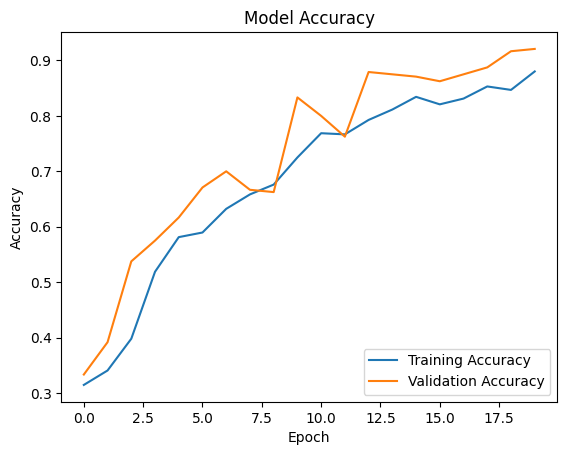

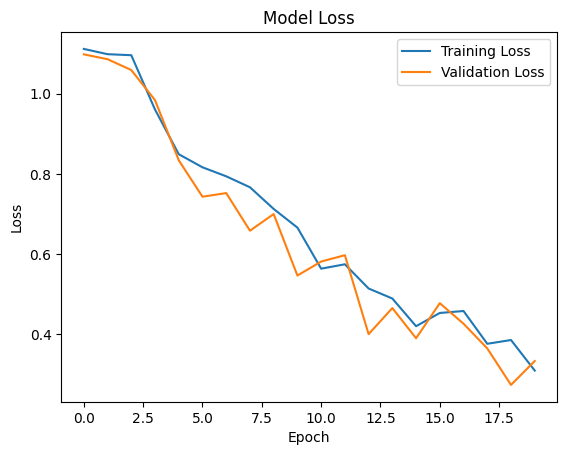

In [9]:
# Plot Akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [10]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9150 - loss: 0.3067
Validation Accuracy: 92.08%


## Konversi Model

In [11]:
save_path = 'mymodel/'
tf.saved_model.save(model, save_path)

simpan ke TF-Lite

In [12]:
# Path untuk menyimpan model TFLite
tflite_model_path = 'model.tflite'

# Konversi model ke format TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Model berhasil disimpan sebagai TFLite di {tflite_model_path}")

Saved artifact at '/tmp/tmpu9tef80c'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140691706579776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140691706760352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140691761850752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140691668528368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140691668527136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140691668522208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140691706920656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140691706910976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140691706913616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140691668606416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14069166860060

simpan ke Tensorflow.js

In [15]:
model.save("model.h5")

# Install tensorflowjs
!pip install tensorflowjs

# Convert model.h5 to model
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2024-11-17 02:41:12.810548: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731811272.834952    4231 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731811272.842026    4231 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


## Inference (Optional)

In [14]:
 pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.1.1
aiohappyeyeballs==2.4.3
aiohttp==3.10.10
aiosignal==1.3.1
alabaster==1.0.0
albucore==0.0.19
albumentations==1.4.20
altair==4.2.2
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
arviz==0.20.0
astropy==6.1.6
astropy-iers-data==0.2024.11.11.0.32.38
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==24.2.0
audioread==3.0.1
autograd==1.7.0
babel==2.16.0
backcall==0.2.0
beautifulsoup4==4.12.3
bigframes==1.25.0
bigquery-magics==0.4.0
bleach==6.2.0
blinker==1.9.0
blis==0.7.11
blosc2==2.7.1
bokeh==3.6.1
Bottleneck==1.4.2
bqplot==0.12.43
branca==0.8.0
CacheControl==0.14.1
cachetools==5.5.0
catalogue==2.0.10
certifi==2024.8.30
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.0
chex==0.1.87
clarabel==0.9.0
click==8.1.7
cloudpathlib==0.20.0
cloudpickle==3.1.0
cmake==3.30.5
cmdstanpy==1.2.4
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.5
cons==0.4.6
contourpy==